# Fama French 3 factor 한국시장 적용

삼성증권 2018년 리서치 리포트 전/후편을 참고함. 

데이터는 월율화시킴

## 0. Import libraries & Data

- KRX 데이터를 바탕으로 생존 편향을 없앰. 
- 그 외 데이터는 NAVER/DAUM finance 데이터, 한국은행 데이터 등을 활용
- 코스피 코스닥 구분하지 않음

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd
import numpy as np

import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

import pickle

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

Data 기간은 아래와 같이 설정

- 추후 beta 계산을 위한 moving window도 설정함

In [4]:
# Global parameters

START = 20140101
END = 20221202

WINDOW = 252 # trading day 기준
# WINDOW = 60 # trading day 기준
# WINDOW = 20 # trading day 기준

In [5]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


## Raw data

### KRX Sector/Industry Grouping

가장 기본적인 grouping으로 KRX 등에서 미리 지정한 산업분류를 사용해본다. 

별도의 노트북에서 KRX industry를 가져와 lv2 dataframe으로 만들었다. 

금융 업종은 제외해야한다. (레버리지가 일반적이지 않음)

In [21]:
with open('INDUSTRY_NAME2CODE.pickle', 'rb') as handle:
    INDUSTRY_NAME2CODE = pickle.load(handle)

In [22]:
INDUSTRY_NAME2CODE

{'서비스업': 0,
 '기타금융': 1,
 '섬유의복': 2,
 '운수창고업': 3,
 '음식료품': 4,
 '화학': 5,
 '철강금속': 6,
 '유통업': 7,
 '건설업': 8,
 '증권': 9,
 '전기전자': 10,
 '의약품': 11,
 '기계': 12,
 '종이목재': 13,
 '통신업': 14,
 '기타제조업': 15,
 '보험': 16,
 '운수장비': 17,
 '전기가스업': 18,
 '비금속광물': 19,
 '은행': 20,
 '광업': 21,
 '농업, 임업 및 어업': 22,
 '의료정밀': 23,
 '반도체': 24,
 '금속': 25,
 '기타서비스': 26,
 '방송서비스': 27,
 '유통': 28,
 '제약': 29,
 '통신장비': 30,
 'IT부품': 31,
 '기계·장비': 32,
 '오락·문화': 33,
 '운송장비·부품': 34,
 '건설': 35,
 '전기·가스·수도': 36,
 '소프트웨어': 37,
 '인터넷': 38,
 '디지털컨텐츠': 39,
 '출판·매체복제': 40,
 '금융': 41,
 '운송': 42,
 '통신서비스': 43,
 '일반전기전자': 44,
 '섬유·의류': 45,
 '컴퓨터서비스': 46,
 '음식료·담배': 47,
 '비금속': 48,
 '종이·목재': 49,
 '의료·정밀기기': 50,
 '기타제조': 51,
 '정보기기': 52,
 '숙박·음식': 53}

- '증권': 9,
- '보험': 16,
- '은행': 20,
- '금융': 41,

In [23]:
industry_df = pd.read_pickle('krx_industry_df_20140101_20221202.pickle')

In [27]:
industry_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,11.0,17.0,7.0,16.0,1.0,1.0,4.0,4.0,11.0,11.0,...,24.0,32.0,24.0,41.0,41.0,41.0,41.0,13.0,NaN,NaN
2022-11-29,11.0,17.0,7.0,16.0,1.0,1.0,4.0,4.0,11.0,11.0,...,24.0,32.0,24.0,41.0,41.0,41.0,41.0,13.0,NaN,NaN
2022-11-30,11.0,17.0,7.0,16.0,1.0,1.0,4.0,4.0,11.0,11.0,...,24.0,32.0,24.0,41.0,41.0,41.0,41.0,13.0,NaN,NaN


In [35]:
industry_df.iloc[-1].isin([9, 16, 20, 41]).sum()

166

In [31]:
non_finance = industry_df.loc[:, (industry_df != 9).all()]
non_finance = non_finance.loc[:, (non_finance != 16).all()]
non_finance = non_finance.loc[:, (non_finance != 20).all()]
non_finance = non_finance.loc[:, (non_finance != 41).all()]

In [37]:
sid_list = non_finance.columns
sid_list

Index(['000020', '000040', '000050', '000070', '000075', '000080', '000087',
       '000100', '000105', '000120',
       ...
       '311960', '348340', '372170', '383930', '389470', '405100', '417500',
       '419080', '425420', '446070'],
      dtype='object', name='ISU_SRT_CD', length=2735)

#### 1. $ f_{mkt} $ Market Excess Return 를 구하기 위한 데이터

사용 데이터:
- 주가 수익률
    - 시가총액 가중을 위해 시가총액 데이터도 필요
- 무위험 수익률

** trading day 기준으로 되어있음

주가 수익률

In [6]:
## stock return
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [7]:
holidays = return_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='trdDd', length=2190, freq=None)

In [8]:
return_df = return_df.loc[tradingdays, :].copy()

In [9]:
monthly_return_df = (return_df + 1).resample('1M').prod() - 1
monthly_return_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.121868,0.438341,0.032110,-6.600660e-03,-0.080429,-0.022059,-2.947846e-02,-0.024096,0.042815,-2.178966e-03,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2014-02-28,0.053807,-0.085737,0.057778,2.220446e-16,0.068513,0.052632,9.813084e-02,0.052469,0.012820,2.715097e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2014-03-31,0.065511,0.324524,0.159664,-1.328904e-02,-0.025921,-0.047143,-4.440892e-16,0.041056,-0.081010,-2.118914e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2014-04-30,0.084991,0.631624,-0.032609,-1.346801e-01,0.008403,0.064468,6.382979e-02,0.053521,0.000000,4.440892e-16,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2014-05-31,-0.036667,-0.116371,-0.093633,-7.782101e-03,0.005556,0.023944,-1.360000e-01,-0.026738,-0.027547,-1.614538e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.047393,-0.050824,-0.045627,1.115942e-01,-0.084000,-0.016502,8.264463e-03,0.002725,-0.017301,-1.413428e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2022-09-30,-0.178109,-0.076700,-0.087649,-2.307692e-01,-0.091703,-0.011745,-1.311475e-01,-0.076087,-0.044014,-5.913978e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2022-10-31,0.093220,-0.123824,-0.043668,6.610169e-02,-0.008013,-0.020374,-3.207547e-02,-0.052941,0.101289,7.619048e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000


무위험 수익률

In [10]:
## risk free rate
## https://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=1073

rf_df = pd.read_excel('bok_risk_free_rate.xls', skiprows=2, nrows=7)

In [11]:
rf_df.set_index(keys=rf_df.columns[0], inplace=True)
rf_df.rename_axis(index=None, inplace=True)
rf_df = rf_df.T
rf_df.index = pd.to_datetime(rf_df.index, format='%Y%m월')


In [12]:
rf_df.columns

Index(['국고채 3년(평균)', '국고채 5년(평균)', '국고채 10년(평균)', '회사채 3년(평균)', 'CD 91물(평균)',
       '콜금리(1일물,평균)', '기준금리'],
      dtype='object')

risk-free rate는 한국은행 10년물 연이율을 일별로 환산하여 사용

In [13]:
rf_df = pd.DataFrame(rf_df[rf_df.columns[2]])
rf_df = rf_df.rename(columns={rf_df.columns[0]: 'bok_10y'})

In [14]:
rf_df

,bok_10y
2014-01-01,3.65
2014-02-01,3.52
2014-03-01,3.54
2014-04-01,3.54
2014-05-01,3.40
...,...
2022-06-01,3.64
2022-07-01,3.30
2022-08-01,3.32
2022-09-01,3.90


#### 2. $ f_{SMB} $ Small Minus Big 을 구하기 위한 데이터

사용 데이터:
- 시가총액 데이터

In [15]:
# Data for 2nd Factor: SMB (Small Minus Big)

marcap_df = pricevolume.get_data("marketcap")

In [16]:
marcap_df = marcap_df.astype(float) # object로 되어있었음

In [17]:
marcap_df = marcap_df.loc[tradingdays, :].copy()

In [18]:
monthly_marcap_df = marcap_df.resample('1M').last()
monthly_marcap_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-31,1.375625e+11,7.518507e+10,3.084218e+11,1.524998e+12,5.604939e+11,1.010993e+10,1.500859e+12,1.830824e+10,2.174746e+12,2.172930e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,1.449643e+11,6.874063e+10,3.262417e+11,1.524998e+12,5.988951e+11,1.064203e+10,1.648140e+12,1.926885e+10,2.202628e+12,2.231977e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,1.544610e+11,9.105747e+10,3.783307e+11,1.504733e+12,5.833712e+11,1.014033e+10,1.648140e+12,2.005995e+10,2.024187e+12,2.184739e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,1.675888e+11,1.485800e+11,3.659939e+11,1.302075e+12,5.882735e+11,1.079406e+10,1.753340e+12,2.113358e+10,2.024187e+12,2.184739e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,1.614439e+11,1.312755e+11,3.317248e+11,1.291942e+12,5.915417e+11,1.105251e+10,1.514886e+12,2.056851e+10,1.968424e+12,2.149311e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,2.807113e+11,6.643168e+10,3.440616e+11,4.479357e+12,5.883654e+11,1.812186e+10,2.139075e+12,2.079454e+10,4.159548e+12,6.589645e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,2.307139e+11,6.133634e+10,3.139048e+11,3.356598e+12,5.344105e+11,1.790902e+10,1.858541e+12,1.921235e+10,3.976469e+12,6.199935e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,2.522212e+11,5.374140e+10,3.001972e+11,3.578475e+12,5.301284e+11,1.754415e+10,1.798927e+12,1.819522e+10,4.379242e+12,6.672311e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3. $ f_{HML} $ High Minus Low 를 구하기 위한 데이터

사용 데이터:
- KRX Funda 데이터 (그 중 PBR)

In [19]:
# Data for 3rd Factor: HML (High Minus Low)

pbr_df = pd.read_pickle('temp_KRX_PBR_20140101_20221202.pkl')

In [20]:
monthly_pbr_df = pbr_df.resample('1M').last()
monthly_pbr_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.61,1.18,0.41,1.34,0.45,NaN,1.07,NaN,1.87,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,0.64,1.08,0.44,1.34,0.48,NaN,1.18,NaN,1.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,0.68,1.43,0.51,1.32,0.47,NaN,1.18,NaN,1.74,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,0.74,2.59,0.52,1.26,0.47,NaN,1.29,NaN,1.68,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,0.71,2.29,0.47,1.25,0.47,NaN,1.11,NaN,1.64,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.80,1.79,0.42,1.74,0.30,NaN,1.95,NaN,2.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,0.66,1.66,0.38,1.34,0.28,NaN,1.69,NaN,1.92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,0.72,1.45,0.36,1.42,0.27,NaN,1.64,NaN,2.11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Make Factor data

- 매년 6월 기준으로 ME (시가총액)으로 정렬한 뒤 10개 그룹으로 나누고
- 각 시가총액 그룹 내에서 pre-ranking beta 로 정렬하고 10개 그룹으로 나눈다. 
    - pre-ranking beta는 각 개별 종목에 대해 time series 방향으로 구한 beta이다. 
        - 당월 수익률($ r_{t} $) 와 전월 수익률($ r_{t-1} $)의 기울기의 합으로 beta를 구함. 
    - pre-ranking beta는 t년 6월을 포함하여 최소 24개월 ~ 최대 60개월 가용한 범위 내에서 구한다. 
        - (이 정도도 없으면 universe에서 탈락시킴)
- 그 뒤 각 시가총액-베타 그룹의 포트폴리오를 동일 가중 월별 수익률을 구한다. 
    - t년의 7월 ~ t+1년 6월까지
    - 그 뒤는 위의 과정을 따라 다시 rebalancing 
- post-ranking beta는 각 포트폴리오 수익률의 전기간 표본을 통해 산출한다. 
    - 마찬가지로 당월 수익률($ r_{t} $) 와 전월 수익률($ r_{t-1} $)의 기울기의 합으로 beta를 구함. 

### Factor 1: Market Excess Return

$$
... + \beta_{m, i} * (R_m - R_f) + ...
$$

### Factor 2: SMB

$$
... + \beta_{SMB, i} * f_{SMB} + ...
$$

> SMB(Small minus Big): 
>
> the average return on the three small portfolios minus is the average return on the big portfolios

$$
SMB = \dfrac{(Small Value + Small Neutral + Small Growth)}{3} – \dfrac{(Big Value +
Big Neutral + Big Growth)}{3}
$$

포트폴리오이기 때문에, 마찬가지로 시가총액 가중을 해야한다.

이 때, market 시가총액 weight를 재활용하지 않고, small/big 으로 만들어진 포트폴리오에서 따로 시가총액 weight를 구한다. 

### Factor 3: HML

$$
... + \beta_{HML, i} * f_{HML} + ...
$$

> HML(High minus Low): 
> 
> the average return on the two value portfolios minus is the average return on the two growth portfolios

$$
SMB = \dfrac{(Small Value + Big Value)}{2} – \dfrac{(Small Growth + Big Growth)}{2}
$$

$Book\text{-}to\text{-}Market \ ratio = \dfrac{장부가}{시가}$

$PBR(Price\text{-}to\text{-}Book \ ratio) = \dfrac{주가}{1 \ 주당 \ 장부가} = \dfrac{시가}{장부가}$

위의 공식에 따라 growth stock 일수록 PBR이 높고, value stock 일수록 PBR이 낮다. 

원래는 Book-to-Market ratio에 기초하기 때문에 High는 value, Low는 growth를 나타낸다는 점을 참고

** return decomposition 및 factor dashboard 완성하고 추가할 예정 **

## 2. Factor Portfolio 의 PnL 

In [39]:
mkt_factor_portfolio_PnL = (mkt_excess_R + 1).cumprod() - 1
SMB_factor_portfolio_PnL = (SMB + 1).cumprod() - 1
HML_factor_portfolio_PnL = (HML + 1).cumprod() - 1

<AxesSubplot: xlabel='trdDd'>

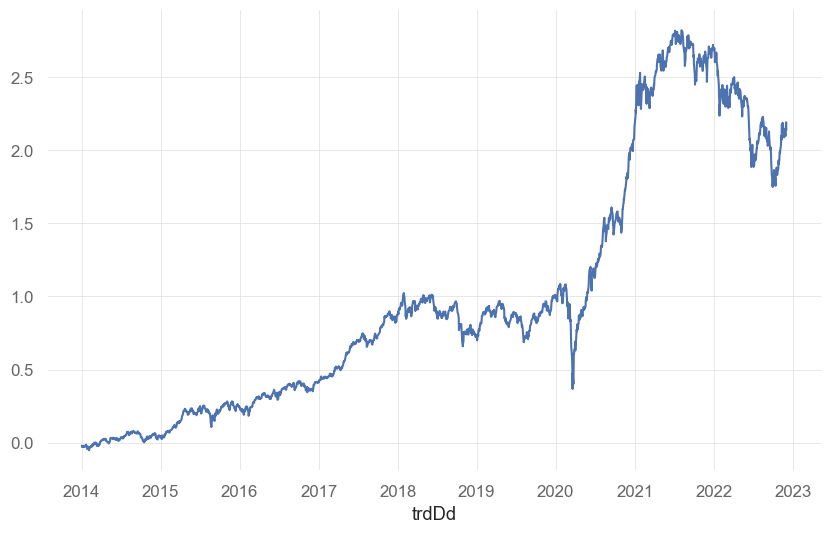

In [40]:
sns.lineplot(data=mkt_factor_portfolio_PnL)

market PnL은 대체로 내가 알고있는 상식대로 잘 나온다. covid 때 팍 찍었다가 바로 반등하는 모습 보여준다. 

하지만 SMB와 HML PnL은 두 팩터가 초과수익을 낸다는 말과는 달리 PnL이 심각하게 꼴아박는다. 

뭔가 factor 만들 때 계산이 잘못되었음을 암시하는 것인가?

<AxesSubplot: xlabel='trdDd'>

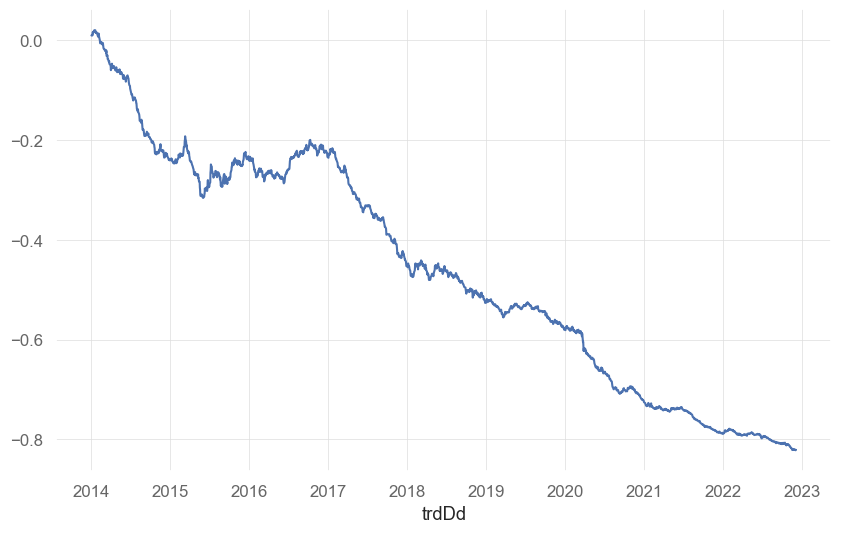

In [41]:
sns.lineplot(data=SMB_factor_portfolio_PnL)

<AxesSubplot: xlabel='trdDd'>

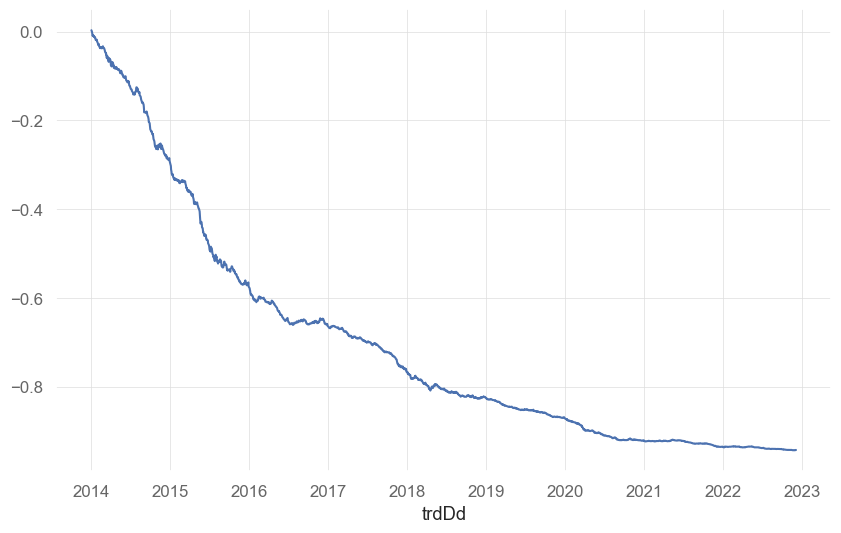

In [42]:
sns.lineplot(data=HML_factor_portfolio_PnL)

## 3. Decompose return into factor returns

각 security의 수익률을 linear regression을 통해 factor로 분해하고, 각 factor의 계수인 beta를 구한다. 

선형회귀를 할 때는 위에서 global 변수로 설정한 `WINDOW`의 기간씩 rolling하며 적용한다. 

따라서 결국 '60일 Beta' 와 같은 계수를 구하게 된다. 

In [45]:
WINDOW

252

In [46]:
return_df.shape

(2190, 3110)

beta를 dataset처럼 생성하려면 

각각의 주식(ii)에 대해 모두 factor decomposition을 위해 linear regression을 하고, 

moving window에 따라 di(기간) 에 대해서도 여러 번 해줘야 하기 때문에 일단 계산량이 많아진다. 

그리고 `WINDOW`를 무작정 키우는 것은 linear factor model이 말 그대로 linear한 관계를 가정하기에 좋지 않을 수 있다. 

그러니까 그냥 최근 `WINDOW`일 만큼만 보자

In [47]:
recent_return_df = return_df.iloc[-WINDOW:, :].copy()

backtest하려는 것이 아니므로 최근 60일 내 전체 값이 존재하지 않는 (nan이 있는) 종목들은 제외하자. 

In [48]:
recent_return_df = recent_return_df.dropna(axis=1, how='any')

In [49]:
recent_return_df.shape

(252, 2548)

In [50]:
recent_mkt_excess_R = mkt_excess_R.iloc[-WINDOW:].copy()
recent_SMB = SMB.iloc[-WINDOW:].copy()
recent_HML = HML.iloc[-WINDOW:].copy()
recent_Rf = Rf.iloc[-WINDOW:].copy()

In [51]:
recent_excess_return_df = recent_return_df.subtract(recent_Rf, axis=0)

행렬을 이용해 한 번에 beta 를 구하도록 하자. 

좌변에서 각 factor의 시계열 series는 행렬 $X$의 각 column이 된다. 

우리가 구하고자 하는 $\beta$가 들어있는 행렬 $W$는 $X$와 행렬 곱 되어야 하므로 각 column이 각 종목에 대한 regression 결과이다. 

마지막으로 우변의 행렬 $b$는 각 종목 return 시계열 series를 모아놓은 것이다. beta 행렬과 같이 각 column에 모아놓은 것이다. 

subscript의 경우 헷갈리지 않게 

- 날짜는 숫자로 (1, 2, 3, ...)
- 종목 번호는 알파벳 소문자로 (a, b, c, ...)

표기하였다. 



$$
XW = b
$$

$$
X = \begin{bmatrix}
f_{mkt, 1} & f_{SMB, 1} & f_{HML, 1} \\
f_{mkt, 2} & f_{SMB, 2} & f_{HML, 2} \\
\vdots & \vdots & \vdots & \\
f_{mkt, n} & f_{SMB, n} & f_{HML, n} \\
\end{bmatrix}
$$ 

$$
W = \begin{bmatrix}
\beta_{mkt, a} & \beta_{mkt, b} & \dots & \beta_{mkt, z} \\
\beta_{SMB, a} & \beta_{SMB, b} & \dots & \beta_{mkt, z} \\
\beta_{HML, a} & \beta_{HML, b} & \dots & \beta_{mkt, z}
\end{bmatrix}
$$

$$
b = \begin{bmatrix}
r_{a, 1} & r_{b, 1} & \dots & r_{z, 1} \\
r_{a, 2} & r_{b, 2} & \dots & r_{z, 2} \\
\vdots & \vdots & \ & \vdots & \\
r_{a, n} & r_{b, n} & \dots & r_{z, n} \\
\end{bmatrix}
$$

이 행렬에서 $W$를 구하면 우리가 원하는 종목별 factor beta들을 구할 수 있다. 

$$
W = X^{-1}b
$$

데이터 중 nan 이 없어야 한다. 

In [71]:
print(f'''
{recent_mkt_excess_R.isna().sum()}
{recent_SMB.isna().sum()}
{recent_HML.isna().sum()}
''')


0
1
0



In [72]:
recent_SMB.fillna(method='ffill', inplace=True)

In [73]:
X = np.array([np.array(recent_mkt_excess_R), np.array(recent_SMB), np.array(recent_HML)]).T
X.shape

(252, 3)

In [74]:
np.isnan(X).sum()

0

In [75]:
b = np.array(recent_excess_return_df)
b.shape

(252, 2548)

In [76]:
np.isnan(b).sum()

0

In [77]:
solution = np.linalg.lstsq(X, b, rcond=None)

In [78]:
W, residuals, rank_of_W, singular_values_of_W = solution

In [79]:
W.shape

(3, 2548)